# Step 1: Environment Setup 

Welcome to the Illinois System Simulation Toolkit (ISST) for AE 443! This notebook will walk you through connecting the various technical, cost, and schedule analyses necessary for your design project. First, let's check that you have all the necessary libraries installed.

In [16]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm

from scipy.optimize import curve_fit

import pint
Units = pint.UnitRegistry()
Units.default_format = '~P'
Units.define('EUR = [currency]')
Units.define('USD = 0.91 * EUR')

If the above cell triggered an error, you're most likely missing some of the required libraries. You can either install them yourself, or run the following cell to install them.

In [17]:
# !{sys.executable} -m pip install -U numpy pandas matplotlib arviz pymc pint

Once you have the required libraries installed and imported, you can proceed to the next step.

# Step 2: Creating the ISST Model Context

Throughout this notebook, we'll be building up a PyMC model context for relating all the parts of your design system together. As such, whenever you want to create a new variable or element of the overall design system, you'll do it within the context:

In [18]:
ISST_Model_Context = pm.Model()

with ISST_Model_Context:
    P1 = pm.Normal('Parameter Name', mu=0, sigma=1)

In the above cell, we've created a parameter, and characterized our uncertainty about it as a normal distribution with mean 0 and standard deviation 1. Note that it has both a variable name 'P1' which will be used to refer to it throughout the code, but it also has a plain language reference to it, 'Parameter Name'. The tag is what will show up in the charts and other reports that will be generated by ISST, so feel free to mix and match your variable names as makes it easiest for you to read the code, while using the tags to determine how they'll show up outside of the code.

Because the parameter was created in the ISST model context (by indenting it beneath the `with ISST_Model_Conxtext` line), ISST knows that the parameter is a part of the overall design system, and it will keep track of its relationship to other parts of the design system.

# Step 3: Creating Risk Tables

ISST wraps around PyMC models, asking you for just a few plain language properties of your design system. Below is the definition of the Risk Table Class:

In [19]:
from dataclasses import dataclass, field

@dataclass
class Risk_Table:
    
    # Name of the Risk Table
    name: str = field(init = True)
    
    # Units of the impact the Risk Table tracks, e.g. 'kg/m^2' using pint's unit registry:
    # https://pint.readthedocs.io/en/stable/user/formatting.html 
    risk_units: str = field(init = True)
    
    # Severity level breakpoints. Each breakpoint corresponds to the point at which the risk table assigns a new utility level.
    # Defined in ascending order of impact. e.g. [0., 6., 12.] for months of schedule delay or [1., 5., 10.] for millions
    # of euros in cost impact. Defaults to five levels capturing a range of 0-10+
    utility_breakpoints: list[float] = field(init = True,
                                             default_factory = lambda: [0.,
                                                                        2.5,
                                                                        5.,
                                                                        7.5,
                                                                        10.])
    
    # Utility associated with each level of impact. Should be the same length as `utility_breakpoints`. Each entry
    # indicates the utility associated with exceeding that breakpoint. e.g. [-1., -3., -5.]. Defaults to a range of 0 to -7.
    utilities: list[float] = field(init = True,
                                   default_factory = lambda: [0.,
                                                              -1.,
                                                              -3.,
                                                              -5.,
                                                              -7.])
    
    utility_names: list[str] = field(init=True,
                                     default_factory = lambda: ['None',
                                                                'Negligible',
                                                                'Moderate',
                                                                'Critical',
                                                                'Catastrophic'])
        
    # Discrete probability levels to be associated with each risk level.
    # Defaults to the geometric means of the probability ranges in ICD 203.
    probability_levels: list = field(init=True,
                                     default_factory = lambda: [0.022,
                                                                0.100,
                                                                0.300,
                                                                0.497,
                                                                0.663,
                                                                0.87,
                                                                0.97])
    
    # Plain language description of each level in the probability range specification.
    probability_names: list[str] = field(init=True,
                                         default_factory=lambda:['Remote',
                                                                 'Very Unlikely',
                                                                 'Unlikely',
                                                                 'Roughly Even Chance',
                                                                 'Likely',
                                                                 'Very Likely',
                                                                 'Almost Certain'])
    
    # Logistic parameters for each level of impact
    L : float = field(init=True, default=10.0)
    k : float = field(init=True, default=1.0)
    x0: float = field(init=True, default=0.0)
    
    def __post_init__(self):        
        
        # Check that utility specification is well-formed
        assert len(self.utility_breakpoints) == len(self.utilities)
        assert len(self.utility_breakpoints) == len(self.utility_names)
        
        # Check that probability specification is well-formed
        assert len(self.probability_levels) == len(self.probability_names)
        assert np.array(self.probability_levels).min() >= 0.0
        assert (np.array(self.probability_levels).max() <= 1.0)
        assert np.all(np.diff(np.array(self.probability_levels)))
        
        logistic_params = self.fit_utilities()
        self.L = logistic_params[0][0]
        self.k = logistic_params[0][1]
        self.x0 = logistic_params[0][2]

            
    def _utility(self,
                impact,
                L = 10.,
                k = 1.,
                x0 = 0.,
                mode = 'logistic',
                u_func = lambda x:x):
        if mode == 'discrete':
            bps = np.atleast_1d(self.utility_breakpoints)
            i_arr = np.atleast_2d(impact)
            return np.array([self.utilities[i] for i in
                    np.sum(
                        np.tile(bps,i_arr.shape[1]).reshape((i_arr.shape[1],bps.shape[0])) < i_arr.T,
                    axis=1) - 1
            ])
        if mode == 'logistic':
            return np.array(L/(1 + np.exp(-k*(impact - x0))))
        if mode == 'custom':
            return u_func(impact)
    
    # Fit a logistics function to the utility levels. Runs by default when the risk table is created.
    # Can be run again if the utility levels are redefined.
    def fit_utilities(self):

        u_func = lambda impact, L, k, x0:self._utility(impact,
                                                       mode='logistic',
                                                       L=L,
                                                       k=k,
                                                       x0=x0)
        params = curve_fit(u_func,
                           xdata=np.array(self.utility_breakpoints),
                           ydata=np.array(self.utilities))
        
        return params


    # Evaluate the utility of a given impact level assuming discrete breakpoints and utility levels.
    def discrete_utility(self,
                         impact):
        
        return self._utility(impact,
                             mode='discrete')
    
    # Evaluate the utility of a given impact level assuming a logistic utility function.
    def logistic_utility(self,
                         impact):
        
        return self._utility(impact,
                             mode='logistic',
                             L = self.L,
                             k = self.k,
                             x0 = self.x0)
    
    # Evaluate the utility of a given impact level using a custom utility function.
    def custom_utility(self,
                       impact,
                       utility_function):
        
        return self._utility(impact,
                             mode='custom',
                             u_func = utility_function)

Let's recreate the Schedule Risk Table from class:

In [20]:
Schedule_Risk_Table = Risk_Table(name='Schedule',
                                 risk_units='months',
                                 utility_breakpoints=[0., 1., 6., 24.,],
                                 utilities=[-1., -3., -5., -9.],
                                 utility_names=['<1 month', '1-6 months', '6 months - 2 years', '>2 years'])

from pprint import pprint as pp
pp(Schedule_Risk_Table)

Risk_Table(name='Schedule', risk_units='months', utility_breakpoints=[0.0, 1.0, 6.0, 24.0], utilities=[-1.0, -3.0, -5.0, -9.0], utility_names=['<1 month', '1-6 months', '6 months - 2 years', '>2 years'], probability_levels=[0.022, 0.1, 0.3, 0.497, 0.663, 0.87, 0.97], probability_names=['Remote', 'Very Unlikely', 'Unlikely', 'Roughly Even Chance', 'Likely', 'Very Likely', 'Almost Certain'], L=-9.031515508293188, k=0.2782443190616007, x0=5.0635206894397795)


/var/folders/_5/8bgnc2d524x354v5l1n2_sc80000gn/T/ipykernel_24352/2080778962.py:99: RuntimeWarning: overflow encountered in exp
  return np.array(L/(1 + np.exp(-k*(impact - x0))))


Risk Tables will be used through ISST, but probably the most imporant thing is their implict definition of a utility function. Risk tables have built in discrete and logistic utility functions, and can also take custom utility functions. First, let's look at the discrete utility function, and see how it evaluates the utility of a 2 month, 12 month, and 36 month delay in the schedule.:

In [21]:
print(f'Discrete utility of a 2 month delay:  {Schedule_Risk_Table.discrete_utility(2.)}')
print(f'Discrete utility of a 12 month delay: {Schedule_Risk_Table.discrete_utility(12.)}')
print(f'Discrete utility of a 36 month delay: {Schedule_Risk_Table.discrete_utility(36.)}')

Discrete utility of a 2 month delay:  [-3.]
Discrete utility of a 12 month delay: [-5.]
Discrete utility of a 36 month delay: [-9.]


When you create a risk table, it automatically fits a logistic utility function to the given utility levels. Let's see how it evaluates the same delays:

In [22]:
print(f'Logistic utility of a 2 month delay:  {Schedule_Risk_Table.logistic_utility(2.):.2f}.')
print(f'Logistic utility of a 12 month delay: {Schedule_Risk_Table.logistic_utility(12.):.2f}.')
print(f'Logistic utility of a 36 month delay: {Schedule_Risk_Table.logistic_utility(36.):.2f}.')

Logistic utility of a 2 month delay:  -2.70.
Logistic utility of a 12 month delay: -7.89.
Logistic utility of a 36 month delay: -9.03.


We can see that by comparison, the logistic utility function is less harsh on the low end of delay, slightly harsher on the high end, but much harsher in the middle. We can see this by plotting the functions:

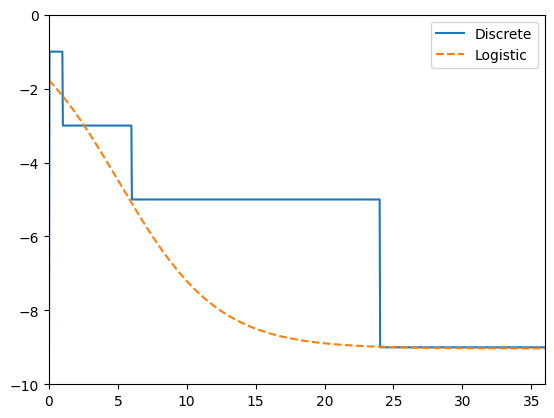

In [23]:
xrange = np.linspace(0., 36., 1000)
plt.plot(xrange, Schedule_Risk_Table.discrete_utility(xrange), '-', label='Discrete')
plt.plot(xrange, Schedule_Risk_Table.logistic_utility(xrange), '--', label='Logistic')
plt.axis((0., 36., -10., 0.))
plt.legend()
plt.show()

Let's say that after looking at the comparison between the logistic and discrete utility functions, we want to adjust the utility levels of the schedule risk table. We think the 6-24 month category is too broad, and want to split it into two categories:

/var/folders/_5/8bgnc2d524x354v5l1n2_sc80000gn/T/ipykernel_24352/2080778962.py:99: RuntimeWarning: overflow encountered in exp
  return np.array(L/(1 + np.exp(-k*(impact - x0))))


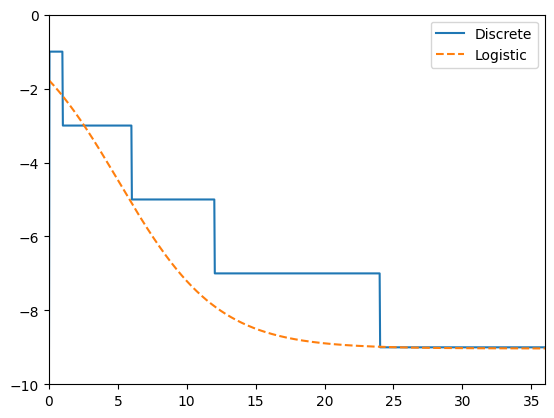

In [24]:
Schedule_Risk_Table.utility_breakpoints = [0., 1., 6., 12., 24.]
Schedule_Risk_Table.utilities = [-1., -3., -5., -7., -9.]
Schedule_Risk_Table.fit_utilities()

plt.plot(xrange, Schedule_Risk_Table.discrete_utility(xrange), '-', label='Discrete')
plt.plot(xrange, Schedule_Risk_Table.logistic_utility(xrange), '--', label='Logistic')
plt.axis((0., 36., -10., 0.))
plt.legend()
plt.show()

In [25]:
@dataclass
class Risk:
    name: str = field(init=True)
    baseline_likelihood: float = field(init=True)
    
    # Schedule Risk Parameterers
    schedule_risk_minimum_value: float = field(init=True, default=0.0)
    schedule_risk_maximum_value: float = field(init=True, default=1.0)
    schedule_risk_most_likely_value: float = field(init=True, default=0.5)
    
    # Cost Risk Parameterers
    cost_risk_minimum_value: float = field(init=True, default=0.0)
    cost_risk_maximum_value: float = field(init=True, default=1.0)
    cost_risk_most_likely_value: float = field(init=True, default=0.5)
    
    # Technical Risk Parameters
    technical_risk_minimum_values: list[float] = field(init=True, default_factory=lambda: [])
    technical_risk_maximum_values: list[float] = field(init=True, default_factory=lambda: [])
    technical_risk_most_likely_values: list[float] = field(init=True, default_factory=lambda: [])

# Step 5: Creating Your System

Now that we've gone over ISST's risk and risk tables, let's go about combining them into a system:

In [26]:
@dataclass
class Design_System:
    
    name: str = field(init=True)
    
    risks: list[Risk] = field(init=True)
    
    model_context: pm.Model = field(init=True)
    
    # System-Wide Schedule Risk Table
    schedule_risk_table: Risk_Table = field(init=True)
    
    # System-Wide Cost Risk Table
    cost_risk_table: Risk_Table = field(init=True)
    
    # System-Wide Technical Risk Tables
    technical_risk_tables: list[Risk_Table] = field(init=True)
    
    def __post_init__(self):            
        assert self.schedule_risk_table is not None
        assert self.cost_risk_table is not None
        assert self.technical_risk_tables is not None
        
        self.schedule_risk_levels = np.zeros(np.asarray(self.schedule_risk_table.utility_breakpoints).shape[0])
        self.cost_risk_levels = np.zeros(np.asarray(self.cost_risk_table.utility_breakpoints).shape[0])
        
        self.max_tech_risk_sizes = np.zeros((len(self.technical_risk_tables)))
        mtrs = 0
        for ii, risk_table in enumerate(self.technical_risk_tables):
            mtrs = max(mtrs, np.asarray(risk_table.utility_breakpoints).shape[0])
            self.max_tech_risk_sizes[ii] = mtrs   
    
    def generate_system_specification(self):
        
        rootpath = os.getcwd()
        system_path = Path(rootpath, self.name)
        os.makedirs(system_path, exist_ok=True)
        
        schedule_df = pd.DataFrame(data = {'Minimum Schedule Impact': np.zeros(len(self.risks)),
                                           'Maximum Schedule Impact': np.zeros(len(self.risks)),
                                           'Most Likely Schedule Impact': np.zeros(len(self.risks))},
                                   index = [risk.name for risk in self.risks])
        
        with open(Path(system_path,f'{self.name} Schedule Risks.csv'), 'w') as f:
            schedule_df.to_csv(f, index=True, header=True)
        
        cost_df = pd.DataFrame(data = {'Minimum Cost Impact': np.zeros(len(self.risks)),
                                       'Maximum Cost Impact': np.zeros(len(self.risks)),
                                       'Most Likely Cost Impact': np.zeros(len(self.risks))},
                               index=[risk.name for risk in self.risks])
        
        with open(Path(system_path,f'{self.name} Cost Risks.csv'), 'w') as f:
            cost_df.to_csv(f, index=True, header=True)
        
        for tech_risk in self.technical_risk_tables:
            tech_risk_df = pd.DataFrame(data = {f'Minimum {tech_risk.name} Impact': np.zeros(len(self.risks)),
                                                f'Maximum {tech_risk.name} Impact': np.zeros(len(self.risks)),
                                                f'Most Likely {tech_risk.name} Impact': np.zeros(len(self.risks))},
                                        index=[risk.name for risk in self.risks])
            
            with open(Path(system_path,f'{self.name} {tech_risk.name} Risks.csv'), 'w') as f:
                tech_risk_df.to_csv(f, index=True, header=True)
        
        return
            
    def read_system_specification(self):
        
        rootpath = os.getcwd()
        system_path = Path(rootpath, self.name)
        
        with open(Path(system_path, f'{self.name} Schedule Risks.csv'), 'r') as f:
            schedule_df = pd.read_csv(f)
        
        with open(Path(system_path, f'{self.name} Cost Risks.csv'), 'r') as f:
            cost_df = pd.read_csv(f)
            
        for risk in self.risks:
                
                risk.schedule_risk_minimum_value        = schedule_df.loc[risk.name, 'Minimum Schedule Impact']
                risk.schedule_risk_maximum_value        = schedule_df.loc[risk.name, 'Maximum Schedule Impact']
                risk.schedule_risk_most_likely_value    = schedule_df.loc[risk.name, 'Most Likely Schedule Impact']
                
                risk.cost_risk_minimum_value            = cost_df.loc[risk.name, 'Minimum Cost Impact']
                risk.cost_risk_maximum_value            = cost_df.loc[risk.name, 'Maximum Cost Impact']
                risk.cost_risk_most_likely_value        = cost_df.loc[risk.name, 'Most Likely Cost Impact']
            
        for tech_risk in self.technical_risk_tables:
            
            with open(Path(system_path, f'{self.name} {tech_risk.name} Risks.csv'), 'r') as f:
                tech_risk_df = pd.read_csv(f)
            
            for risk in self.risks:
                
                risk.technical_risk_minimum_values.append(tech_risk_df.loc[risk.name, f'Minimum {tech_risk.name} Impact'])
                risk.technical_risk_maximum_values.append(tech_risk_df.loc[risk.name, f'Maximum {tech_risk.name} Impact'])
                risk.technical_risk_most_likely_values.append(tech_risk_df.loc[risk.name, f'Most Likely {tech_risk.name} Impact'])
        
        return
    
    def analyze_system(self):
        
        risk_schedule_mins = []
        risk_schedule_maxs = []
        risk_schedule_mls = []
        
        risk_cost_mins = []
        risk_cost_maxs = []
        risk_cost_mls = []
        
        for risk in self.risks:
            risk_schedule_mins.append(risk.schedule_risk_minimum_value)
            risk_schedule_maxs.append(risk.schedule_risk_maximum_value)
            risk_schedule_mls.append(risk.schedule_risk_most_likely_value)
            
            risk_cost_mins.append(risk.cost_risk_minimum_value)
            risk_cost_maxs.append(risk.cost_risk_maximum_value)
            risk_cost_mls.append(risk.cost_risk_most_likely_value)
            
        
        s_min = min(risk_schedule_mins)
        s_max = max(risk_schedule_maxs)
        s_rng = s_max - s_min
        
        s_min_arr = (np.asarray(risk_schedule_mins) - s_min)/s_rng
        s_max_arr = (np.asarray(risk_schedule_maxs) - s_min)/s_rng
        s_ml_arr = (np.asarray(risk_schedule_mls) - s_min)/s_rng
        
        s_mu = (s_min_arr + 4 * s_ml_arr + s_max_arr) / 6
        s_sigma = np.sqrt((s_mu - s_min_arr)*(s_max_arr - s_mu)/7)
        
        c_min = min(risk_cost_mins)
        c_max = max(risk_cost_maxs)
        c_rng = c_max - c_min
        
        c_min_arr = (np.asarray(risk_cost_mins) - c_min)/c_rng
        c_max_arr = (np.asarray(risk_cost_maxs) - c_min)/c_rng
        c_ml_arr = (np.asarray(risk_cost_mls) - c_min)/c_rng
        
        c_mu = (c_min_arr + 4 * c_ml_arr + c_max_arr) / 6
        c_sigma = np.sqrt((c_mu - c_min_arr)*(c_max - c_mu_arr)/7)
        
        tech_risk_mins = np.zeros((len(self.risks), len(self.technical_risk_tables)))
        tech_risk_maxs = np.zeros((len(self.risks), len(self.technical_risk_tables)))
        tech_risk_mls = np.zeros((len(self.risks), len(self.technical_risk_tables)))
        
        t_mins = np.zeros(len(self.technical_risk_tables))
        t_maxs = np.zeros(len(self.technical_risk_tables))
        t_mls = np.zeros(len(self.technical_risk_tables))
        
        t_mus = np.zeros(len(self.technical_risk_tables))
        t_sigmas = np.zeros(len(self.technical_risk_tables))
        
        for jj, tech_risk in enumerate(self.technical_risk_tables):
            for ii, risk in enumerate(self.risks):    
                tech_risk_mins[ii, jj] = risk.technical_risk_minimum_values[jj]
                tech_risk_maxs[ii, jj] = risk.technical_risk_maximum_values[jj]
                tech_risk_mls[ii, jj] = risk.technical_risk_most_likely_values[jj]
            
            t_mins[jj] = min(tech_risk_mins[:, jj])
            t_maxs[jj] = max(tech_risk_maxs[:, jj])
            t_mls[jj] = max(tech_risk_mls[:, jj])
            
            t_rngs = t_maxs - t_mins
            
            t_mins_scaled = (np.asarray(tech_risk_mins[:, jj]) - t_mins[jj])/t_rngs[jj]
            t_maxs_scaled = (np.asarray(tech_risk_maxs[:, jj]) - t_mins[jj])/t_rngs[jj]
            t_mls_scaled = (np.asarray(tech_risk_mls[:, jj]) - t_mins[jj])/t_rngs[jj]
            
            t_mus[jj] = (t_mins_scaled[jj] + 4 * t_mls_scaled[ jj] + t_maxs_scaled[jj]) / 6
            t_sigmas[jj] = np.sqrt((t_mus[jj] - t_mins_scaled[jj])*(t_maxs_scaled[jj] - t_mus[jj])/7)
        
        with self.model_context:
            schedule_vars = pm.Deterministic('Schedule',
                                             pm.Beta('Schedule_Scaled', mu=s_mu, sigma=s_sigma, shape=len(self.risks)) * s_rng + s_min)
            cost_vars = pm.Deterministic('Cost',
                                         pm.Beta('Cost_Scaled', mu=c_mu, sigma=c_sigma, shape=len(self.risks)) * c_rng + c_min)
            technical_vars = pm.Deterministic(
                pm.Beta('Technical_Scaled', mu=t_mus, sigma=t_sigmas, shape=(len(self.risks), len(self.technical_risk_tables))) * t_rngs + t_mins)
            
            risk_priors = []
            for ii, risk in enumerate(self.risks):
                risk_priors.append(risk.basline_likelihood)
                
            total_schedule_impact = pm.math.dot(schedule_vars, np.asarry(risk_priors))
            total_cost_impact = pm.math.dot(cost_vars, np.asarry(risk_priors))
            total_technical_impact = pm.math.dot(technical_vars.T, np.asarry(risk_priors)).T
            
            idata = pm.sample()  
        
        return idata
        

In [27]:
strike = Risk(name='Strike', baseline_likelihood=0.02)
flood = Risk(name='Flood', baseline_likelihood=0.20)

In [28]:
Cost_Risk_Table = Risk_Table(name='Cost', risk_units='EUR')
Weight_Risk_Table = Risk_Table(name='Weight', risk_units='kg')

/var/folders/_5/8bgnc2d524x354v5l1n2_sc80000gn/T/ipykernel_24352/2080778962.py:112: OptimizeWarning: Covariance of the parameters could not be estimated
  params = curve_fit(u_func,


In [29]:
System = Design_System(name = 'Demo',
                       risks=[strike, flood],
                       model_context=ISST_Model_Context,
                       schedule_risk_table=Schedule_Risk_Table,
                       cost_risk_table=Cost_Risk_Table,
                       technical_risk_tables=[Weight_Risk_Table])

System.generate_system_specification()